# Статистика, DS-поток
## Практическое задание 1


**Правила:**

* Дедлайн **14 сентября 16:00**. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить телеграм-боту `@miptstats_ad21_bot`.
* Прислать нужно ноутбук в формате `ipynb`.
* Решения, размещенные на каких-либо интернет-ресурсах не принимаются. Публикация решения может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качествие основы, ничего не удаляя из него.
* Никакой код из данного задания при проверке запускаться не будет.

**Баллы за задание:**

* Задача 1 -  10 баллов
* Задача 2 -  5 баллов
* Задача 3 -  5 баллов

**Важность задач:**

* *средне-высокая:* задачи 1, 2, 3;

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt

%matplotlib inline

---
## Задача 1.

Реализуйте метод Монте-Карло и метод прямоугольников численного интегрирования функции. Реализация должна уметь вычислять интеграл вида:
$$ \int\limits_{l_1}^{h_1} ... \int\limits_{l_d}^{h_d} f(x_1, ... , x_d) dx_1 ... dx_d $$

*Детали реализации*: на вход функции подаются векторы $l = (l_1, ... , l_d)$ и $h = (h_1, ... ,h_d)$, число $n$ -- максимальное допустимое число вызовов функции $f$ (если вы не делаете лишних вызовов, оно равно числу точек-центров отрезков, прямоугольников, параллелипипедов, и т.д. в многомерных случаях). Использование циклов, кроме циклов по числу интегралов $d$, **наказуемо**.

Для быстрой работы метода прямоугольников мы будем использовать функцию <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html">`numpy.meshgrid`</a>. Ниже есть пример ее использования. Как всегда, настоятельно советуем читать документацию.

In [3]:
# Предположим, мы хотим получить координаты всех целых точек (x, y), 
# таких, что x лежит в промежутке [5, 6], а y - в промежутке [-3, -1]

linspace_x = [5, 6]  
linspace_y = [-3, -2, -1]

# возвращает матрицы с координатами сетки,
# задаваемой проекциями точек на оси координат
X, Y = np.meshgrid(linspace_x, linspace_y)

print("X: ", X)  # linspace_x повторилась len(linspace_y) раз по оси 0
print("Y: ", Y)  # linspace_y повторилась len(linspace_x) раз по оси 1

# преобразуем исходный формат к вектору точек
np.stack([X, Y]).reshape(2, -1).T

X:  [[5 6]
 [5 6]
 [5 6]]
Y:  [[-3 -3]
 [-2 -2]
 [-1 -1]]


array([[ 5, -3],
       [ 6, -3],
       [ 5, -2],
       [ 6, -2],
       [ 5, -1],
       [ 6, -1]])

In [224]:
class Integrator:
    
    @staticmethod
    def integrate(f, low, high, n, method="rectangle"):
        """
        Вычисление определенного интеграла.
        
        Аргументы:
        f --- векторная функция d-мерной переменной.
            Реализация функции на вход принимает матрицу (n, d),
            где n - число точек, в которых нужно вычислить функцию,
            а d - размерность пространства переменных.
            Функция должна вернуть вектор размерности n.
        low, high --- нижние и верхние пределы интегрирования.
            Передаются в том же порядке, в котором функция 
            принимает аргументы).
        n --- максимальное число вызовов функции f.
        method --- метод ("rectangle" или "monte_carlo").
                            
        Возвращает приближенное значение интеграла.
        """
        
        assert len(low) == len(high)
        low, high = map(np.array, [low, high])
        n = int(n)

        return Integrator.methods[method](f, low, high, n)
    
    
    def integrate_monte_carlo(f, low, high, n):
        """Метод монте-карло"""
        
        dim = len(high)

        dots =  np.array([np.random.uniform(low[i], high[i], n) for i in range(dim)])
        dots = dots.T
        # случайные точки, в которых будем вычислять функцию
        
        diff = (high - low) # длины отрезков разбиения
        
        # вычисление интеграла
        y = f(dots)
        integral = np.prod(diff) / n * np.sum(y)
        
        return integral
    
    
    def integrate_rectangle(f, low, high, n):
        """Метод прямоугольников"""
        
        dim = len(high)
        
        n_rounded =  int(np.trunc(np.power(n, 1 / dim))) # количество точек, в которых вычисляем функцию
        
        diff =  (high - low) / n_rounded # длины отрезов разбиения
    
        centers_of_ranges = np.zeros((dim, n_rounded))
        
        # для каждой размерности найдите центры отрезков разбиения 
        new_low = low.reshape(dim, 1)
        new_diff = diff.reshape(dim, 1)
        new_diff = new_diff * np.ones((dim, n_rounded))
        centers_of_ranges = centers_of_ranges + new_low - new_diff / 2
        new_diff = new_diff.cumsum(axis=1)
        centers_of_ranges = centers_of_ranges + new_diff
        
        centers = np.meshgrid(*centers_of_ranges)
        f_vals = f(np.stack(centers).reshape(dim, -1).T)
        return f_vals.sum() * np.prod(diff)
    
    
    methods = {
        "rectangle": integrate_rectangle,
        "monte_carlo": integrate_monte_carlo
    }

Вычислите $\int\limits_0^1 \int\limits_3^4 \left(x^2 + y^2\right) dxdy$ на миллионе запусков функции $f(x, y) = x^2+y^2$ двумя рассмотренными методами. Измерьте время работы методов и сравните результат с истинными значением интеграла. Различается ли время работы методов? Объясните результаты с точки зрения теории.

In [225]:
square_sum = lambda x: np.sum(x**2, axis=0)

In [226]:
import time

integral_ist = lambda x1, y1, x2, y2: x2 * y2 * (x2 ** 2 + y2 ** 2) / 3 + x1 * y1 * (x1 ** 2 + y1 ** 2) / 3 - (x1 * y2 * (x1** 2 + y2 ** 2) / 3) - (x2 * y1 * (x2 ** 2 + y1 ** 2) / 3) 
integral = integral_ist(0, 3, 1, 4)

I = Integrator()

# Тест метода Монте-Карло 
start = time.time()
integral_mk = I.integrate(square_sum, [0, 3], [1, 4], 1e6, 'monte_carlo')
end = time.time()
print(f'время работы метода Монте-Карло: {end - start}')
print(f'абсолютная ошибка метода Монте-Карло: {abs(integral_mk - integral)}')

# Тест метода прямоугольников
start = time.time()
integral_r = I.integrate(square_sum, [0, 3], [1, 4], 1e6, 'rectangle')
end = time.time()
print(f'время работы метода прямоугольников: {end - start}')
print(f'абсолютная ошибка метода прямоугольников: {abs(integral_r - integral)}')

время работы метода Монте-Карло: 0.042496681213378906
абсолютная ошибка метода Монте-Карло: 0.0010433433895880029
время работы метода прямоугольников: 0.026356220245361328
абсолютная ошибка метода прямоугольников: 1.6666666624587378e-07


**Вывод:** на небольшой размерности (тестировали на размерности 2) метод прямоугольников работает лучше как по времени, так и по точности. При этом абсолютная ошибка метода прямоугольников совсем незначительная, в то время как ошибка метода Монте-Карло больше на 3-4 порядка. То, что метод Монте-Карло работает дольше, я связываю с тем, что для метода Монте-Карло надо генерировать выборку.

---
## Задача 2.

Для $d = 1...8$ оцените скорость сходимости методов для интеграла
$$\int\limits_0^1 ... \int\limits_0^1 \sum_{i=1}^{d} x_i^2 \prod_{i=1}^{d}dx_i$$

Т.е. $\int\limits_0^1 x_1^2 dx_1$, $\int\limits_0^1 \int\limits_0^1 \left( x_1^2 + x_2^2 \right) dx_1 dx_2$ и так далее.

Вычислите точное значение этого интеграла и для каждого $d$ постройте график зависимости вычисленного значения интеграла от числа $n$ вызовов подынтегральной функции (в корректном решении равно числу точек-центров), которое разрешено использовать для каждого метода вычисления интеграла. Рекомендуется рассмотреть значения $n$ вплоть до $d \times 1000$.

Для вашего удобства, мы написали функцию, которая строит графики в этой задаче.

In [227]:
max_dim = 8


def plot_convergence(f, low, high, n_list, theoretical_value, max_dim):
    """
    Построение графиков сходимости методов Монте-Карло и прямоугольников.
    
    Аргументы:
        f --- векторная функция d-мерной переменной.
            Реализация функции на вход принимает матрицу (n, d),
            где n - число точек, в которых нужно вычислить функцию,
            а d - размерность пространства переменных.
            Функция должна вернуть вектор размерности n.
        low, high --- нижние и верхние пределы интегрирования.
            Передаются в том же порядке, в котором функция 
            принимает аргументы).
    n_list --- список.
    theoretical_value --- точное значение интеграла.
    max_dim --- максимальная кратность интеграла.
    """
    
    source = np.arange(max_dim) + 1
    i = Integrator()
    
    for d in source:
        rectangles_computed = np.zeros(len(n_list))
        monte_carlo_computed = np.zeros(len(n_list))
        
        for n in np.arange(len(n_list)):
            mn = i.integrate(f, low[:d], high[:d], n_list[n],
                             method="monte_carlo")
            rc = i.integrate(f, low[:d], high[:d], n_list[n])
            monte_carlo_computed[n] = mn
            rectangles_computed[n] = rc
        
        plt.figure(figsize=(15, 5))
        plt.title('Зависимость вычисленного значения интеграла' +
                  ' от n для d = {}'.format(d), fontsize=14)      
        plt.xlabel("Число вызовов функции", fontsize=14)
        plt.ylabel("Значение интеграла", fontsize=14)
        plt.plot(n_list, monte_carlo_computed, color='blue',
                 label="по методу Монте-Карло")
        plt.plot(n_list, rectangles_computed, color='magenta',
                 label="по методу прямоугольников")
        plt.axhline(y=theoretical_value[d - 1], color='indigo',
                    linestyle='--', label="истинное значение")
        plt.legend(fontsize=14)

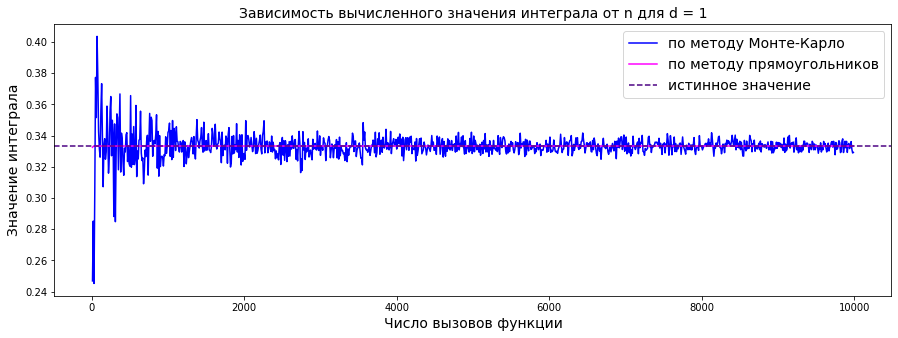

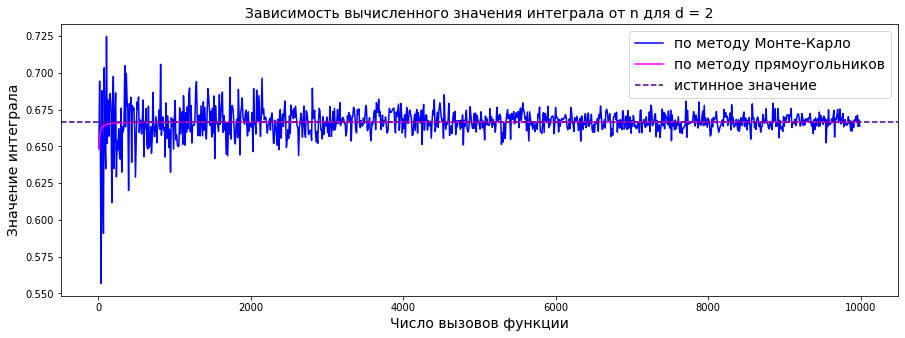

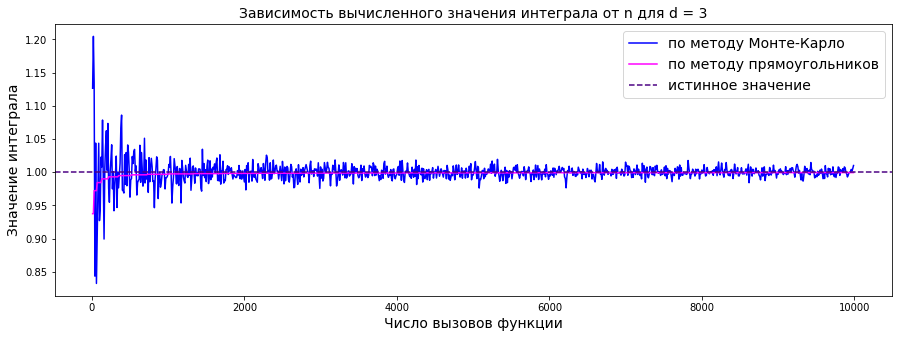

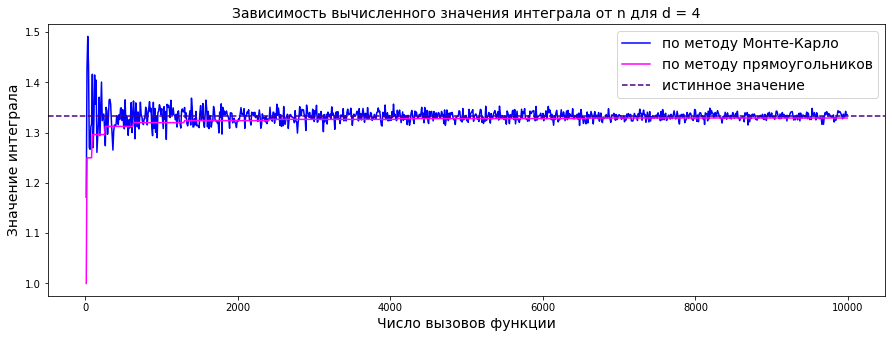

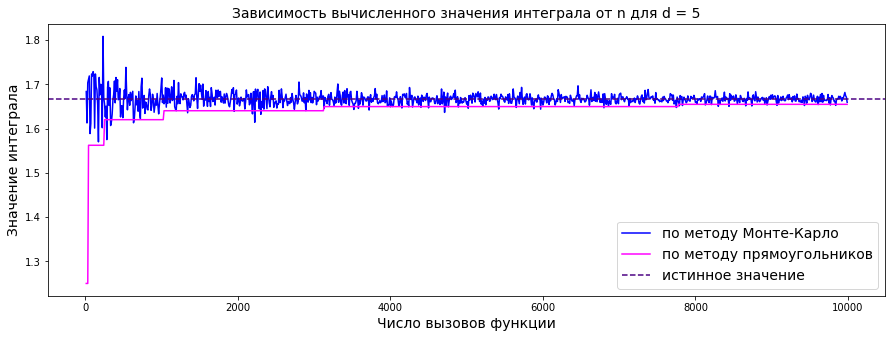

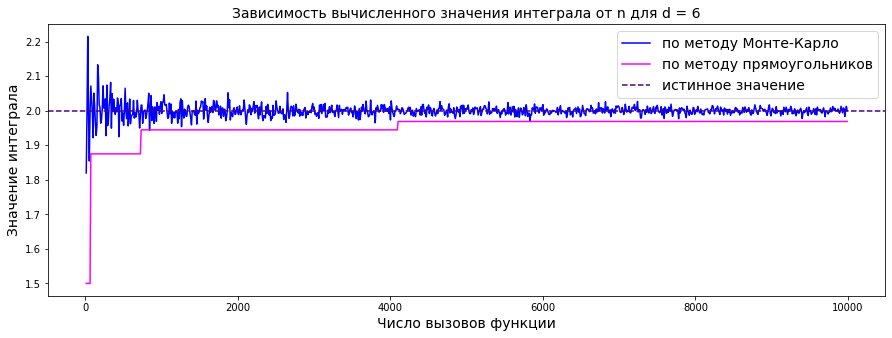

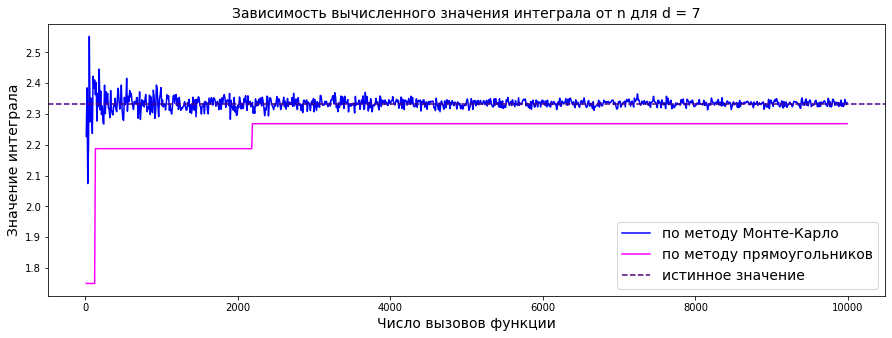

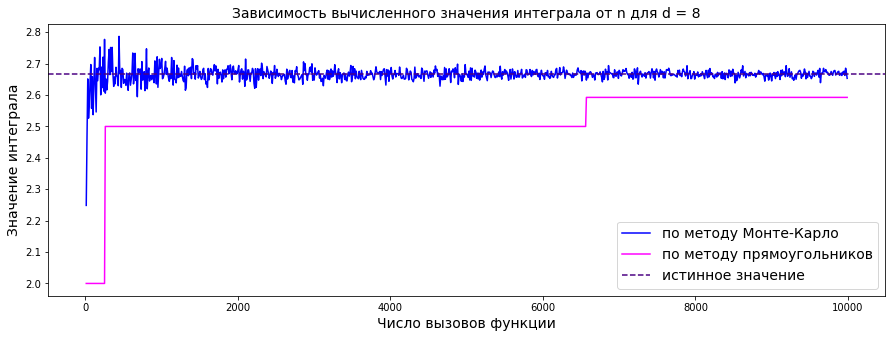

In [228]:
theor_value = (np.arange(max_dim) + 1) / 3

low = np.zeros(max_dim)
high = np.ones(max_dim)

plot_convergence(f=square_sum, low=low, high=high, n_list=np.arange(10, 10000, 10), theoretical_value=theor_value, max_dim=max_dim)

Какой метод и при каких $d$ сходится быстрее? Предположите, в каком случае выгоднее использовать тот или иной метод.

С чем связано такое поведение графиков?

Сравните результаты с предыдущей задачей.

**Вывод:** действительно, как и в предыдущей задаче при малых размерностях (до 3-4) значительно лучше себя показывает метод прямоугольников: значение начинает сходиться с истинным очень быстро. Но начиная с размерности 5, метод Монте-Карло показывает себя лучше метода прямоугольников, при этом с ростом $d$ погрешность метода Монте-Карло увеличивается незначительно, а вот абсолютная погрешность метода прямоугольников быстро достигает нескольких сотых долей уже при $n = 6$. Дело в том, что при росте размерности количество 'прямоугольников', на которые мы разбиваем, увеличивается экспоненциально, соответственно, и длина отрезков разбиения по каждой координате увеличивается экспоненциально, а значит, экспоненциально увеличивается и погрешность вычисления.

---
## Задача 3.

Вам предлагается численно посчитать многомерный интеграл Пуассона для размерности $d=5$ и некоторой симметричной положительно определенной матрицы $A$, которую вы выберете сами. Зависит ли интеграл от выбора $A$? 
$$\int\limits_{\mathbb{R}^d} exp( - x^T A x) dx $$

Сравните результаты двух методов с истинным значением интеграла. Как вы думаете, какой метод выдает более точный результат? Количество итераций каждого метода должно быть не менее $10^6$. Теоретическое вычисление интеграла можно не приводить, достаточно написать ответ.

**Комментарий:** В этой задаче особенно важно выбрать правильные пределы интегрирования. 
Например, для единичной матрицы достаточно взять интеграл с пределами внутри области $[-5, 5]^5$

В связи с этим просим Вас ответить на наводящие вопросы. 
1. Что будет, если выбрать слишком большие пределы в методе Монте-Карло? 
2. Что может произойти, если выбрать слишком большие пределы в методе прямоугольников?

В этой задаче нельзя использовать циклы. Для вычисления функции в точках используете простые векторно-матричные операции в `numpy`.

Возьмем матрицу $A = diag(1, 2, 3, 2, 1)$.

In [329]:
A = np.array([[1, 0, 0, 0, 0], [0, 2, 0, 0, 0], [0, 0, 3, 0, 0], [0, 0, 0, 2, 0], [0, 0, 0, 0, 1]])


def func_Poisson(x):
    ax = np.einsum('ij,kj->ik', A, x)
    b = np.einsum('ki,ik->k', x, ax)
    return np.exp(-b)

lim1 = np.array([4.5, 3.1, 2.9, 3.1, 4.5])
lim2 = np.array([2.5, 2.4, 2.2, 2.4, 2.5])

I = Integrator()

real_value = np.power(np.pi, 2.5) / 2 / np.power(3, 0.5)

r_int = I.integrate(f=func_Poisson, low=lim1 * (-1), high=lim1, n=1000000, method='rectangle')
mk_int = I.integrate(f=func_Poisson, low=np.ones(5) * (-lim), high=np.ones(5) * lim2, n=1000000, method='monte_carlo')
np.abs(r_int - real_value), np.abs(mk_int - real_value)


# n_iter = 100
# rez = np.array([])
# for lim1 in np.arange(2, 5.5, 0.5):
#     for lim2 in np.arange(2, 3.2, 0.2):
#         for lim3 in np.arange(2, 3.2, 0.2):
#             res = 0
#             lim = np.array([lim1, lim2, lim3, lim2, lim1])
#             for i in range(n_iter):
#                 r_int = I.integrate(f=func_Poisson, low=-lim, high=lim, n=1000000, method='monte_carlo')
#                 res += np.abs(r_int - real_value)
#             res /= n_iter
#             if (res < 0.045):
#                 print(f'lim = {lim}, res = {res}')

(3.2792435433748324e-11, 9.78277559058327e-05)

Опытным путем нашли оптимальные пределы интегрирования для каждого из методов. Если в методе Монте-Карло взять слишком большие пределы, то точки будут вылетать из места, где функция принимает большие значения (близко к нулю), поэтому интеграл стремится к нулю. В методе прямоугольников же у нас с ростом пределов растет объем, а точки мы генерируем сами, поэтому у нас остается достаточно точек, где функция не близка к нулю, поэтому у нас интеграл улетает в бесконечность с ростом пределов.

Рассмотрим отношение интегралов: 
$$
F(t) = \frac{ \int\limits_{-\infty}^{t_1} ... \int\limits_{-\infty}^{t_k} exp \left( - \frac12 x^T A x \right) dx}{ \int\limits_{\mathbb{R}^n} exp \left( - \frac12 x^T A x \right) dx}.
$$
В чем его вероятностный смысл?

Насколько я понял, это функция распределения $k$-мерного нормального распределения с вектором средних $\vec{0}$ и матрицей ковариации $A^{-1}$.